In [305]:
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import random
import os

%matplotlib inline

In [306]:
import seaborn as sns

sns.set(style="ticks")
sns.set_style({"xtick.direction": "in","ytick.direction": "in","xtick.top":True,"ytick.right":True,"axes.grid":True})

In [307]:
def read_file(filename):
    lines = []
    with open(filename, 'r') as myfile:
        lines = [line.rstrip('\n') for line in myfile]
    return lines

def json_read_file(filename):
    with open(filename, "r") as read_file:
        return json.load(read_file)
    
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def calcul_fair(values):
    '''
    @brief:
        calculate fairness
    @params:
        values: a list of values
    '''
    n = len(values)
    if sum(values) != 0.:
        return pow(sum(values), 2)/(n*sum(pow(values, 2)))
    else:
        return 1.

In [308]:
metrics = ['fct-avg', 'fct-p90', 'fct-p99', 'fct-wasserstein', 'n_reject']

In [309]:
COLORS = [
          "#3978af", 
          "#d1342b",
          "#559d3f",
          "#ef8532", 
          "#634295", 
          "#a65d34", 
          "#aecde1", 
          "#b4dc93",
          "#ee9e9b", 
          "#f4c07b", 
          "#c6b4d3",
          "#fffea6",
          "#df3583"
]

In [310]:


COLORS_DICT = {
    'sed': '#559d3f',
    'sed2': '#559d3f',
    'lsq': "#aecde1",
    'lsq2': "#aecde1",
#     'lsq2': "#634295",
    'active-wcmp': "#a65d34",
    'weight': "#ef8532", 
    'ecmp': "#d1342b", 
    'oracle': '#3978af',
    'oracle2': '#3978af',
    'gsq': "#634295",
    'gsq2': "#634295",
    'hlb-ada': "#17becf",
#     'hlb': "#17becf",
#     'hlb2': "#17becf",
    'hlb': "#df3583",
    'hlb2': "#df3583",
}

MARKER_DICT = {
    'lsq2':       "+",
    'ecmp':       "^",
    'lsq':       "o",
    'hlb':    "x",
    'hlb-ada': 'x',
    'active-wcmp': "p",
    'weight':   "d",
    'sed':   "v",
    'gsq': '+',
    'gsq2': '+',
    'oracle': '$o$',
}

LINESTYLE_DICT = {
    'lsq2':       "-",
    'active-wcmp': '-',
    'ecmp':       "-",
    'lsq':       "-",
    'hlb':    "-",
    'hlb-ada': '-',
    'weight':   "-",
    'sed':   "-",
    'gsq': '-',
    'gsq2': '-',
    'oracle': '-'
}

method_mapper = {
    'ecmp': 'ECMP',
    'weight': 'WCMP',
    'lsq': 'LSQ',
    'lsq2': 'LSQ2',
    'sed': 'SED',
    'sed2': 'SED2',
    'gsq': 'GSQ',
    'gsq2': 'GSQ2',
    'oracle': 'Oracle',
    'oracle2': 'Oracle2',
    'active-wcmp': 'AWCMP',
    'hlb': 'HLB',
    'hlb2': 'HLB2',
    'hlb-ada': 'HLB',
}

In [311]:
fig_dir = '/home/yzy/Load-Balancer/data/figures/simulation/hlb-ton'

# First Impression

In [312]:
experiment_name = 'first-impression-reduce'
setups = !ls ../../data/simulation/hlb-ton-$experiment_name/
root_dir = '../../data/simulation/hlb-ton-'+experiment_name # data directory
methods = !ls ../../data/simulation/hlb-ton-$experiment_name/{setups[1]}
metrics = ['fct-avg', 'fct-p99']

In [317]:
metric_all = {}
n_404 = 0
for setup in setups[1:2]:
    print('process setup {}'.format(setup))
    metric_all[setup] = {}
    methods = !ls {root_dir+'/'+setup}
    for method in methods:
        print('process method {}'.format(method))
        metric_all[setup][method] = {}
        folder_ = os.path.join(root_dir, setup, method)
        rates_ = !ls $folder_
        rates_ = [float(r.lstrip('rate')) for r in rates_]
        for rate in rates_:
            metric_all[setup][method][rate] = {}
            folder_rate = os.path.join(folder_, 'rate{:.3f}'.format(rate))
            episodes = !ls $folder_rate
            episodes = [i.rstrip('.json') for i in episodes if '.json' in i]
            for episode in episodes:
                if len(episodes) == 0:
                    print("No episode in", folder_rate)
                filename = os.path.join(folder_rate, '{}.json'.format(episode))
                metric_all[setup][method][rate][episode] = {}
                try:
                    f = json_read_file(filename)
                    for metric in metrics:
                        metric_all[setup][method][rate][episode][metric] = f['clt0'][metric]
                except FileNotFoundError:
                    n_404 += 1
                    print(">> (total {}) Not found:".format(n_404), filename)
                    for metric in metrics:
                        metric_all[setup][method][rate][episode][metric] = np.nan

process setup 4lb-128as-1worker-1stage-exp-0.50cpumu
process method active-wcmp
process method ecmp
process method gsq2
process method hlb
process method hlb-ada
process method lsq
process method oracle
process method sed
process method weight


In [ ]:
for i, setup in enumerate(setups):
    print(i, setup)

In [318]:
# plot
methods = ['oracle', 'hlb-ada', 'sed', 'lsq',  'gsq2', 'active-wcmp', 'weight', 'ecmp']
setup = setups[1]
rate = 0.885

In [319]:
all_fcts = {}
for method in methods:
    all_fcts[method] = []
    folder_ = os.path.join(root_dir, setup, method)
    folder_rate = os.path.join(folder_, 'rate{:.3f}'.format(rate))
    episodes = !ls $folder_rate
    episodes = [i.rstrip('.json') for i in episodes if '.json' in i]
    for episode in episodes:
        if len(episodes) == 0:
            print("No episode in", folder_rate)
        filename = os.path.join(folder_rate, '{}.json'.format(episode))
    try:
        f = json_read_file(filename)
        all_fcts[method] += f['clt0']['all_fct']
    except FileNotFoundError:
        n_404 += 1
        print(">> (total {}) Not found:".format(n_404), filename)

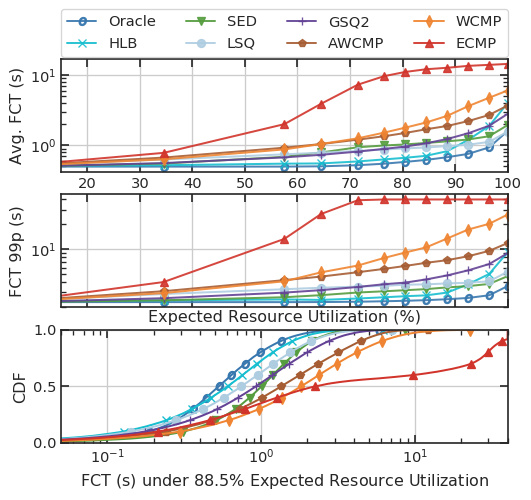

In [323]:
fig, axs = plt.subplots(3, figsize=(6, 5), dpi=96, sharex=False, sharey=False)
# fig.suptitle('Hour 3 (680 queries/s)', y=1.06)
i = 0
for metric, ylabel in zip(['fct-avg', 'fct-p99'], ['Avg. FCT (s)', 'FCT 99p (s)']):
    for method in methods:

        data_ = metric_all[setup][method]
        rates_ = np.sort(list(data_.keys()))

        y = []
        for r in rates_:
            data_episodes = [data_[r][episode][metric] for episode in data_[r].keys()]
            if len(data_episodes) == 0:
                print(setup, method, r)
            y.append(np.mean(data_episodes))

        color = COLORS_DICT[method]
        marker = MARKER_DICT[method]
        linestyle = LINESTYLE_DICT[method]

        axs[i].semilogy(rates_, y, linestyle=linestyle, marker=marker, markersize=6, color=color, label=method_mapper[method], alpha=0.9)
    axs[i].set_ylabel(ylabel)
    i += 1
        

axs[0].legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
   ncol=4, mode="expand", borderaxespad=0.)
plt.sca(axs[0])
# plt.xticks([], [])
plt.xticks(np.arange(0.1, 1.1, 0.1), range(10, 110, 10), rotation=0)
plt.xlim([0.15, 1.])
plt.grid(True)

plt.sca(axs[1])
plt.xticks(np.arange(0.1, 1.1, 0.1), range(10, 110, 10), rotation=0, color='w')
plt.xlim([0.15, 1.])
plt.grid(True)

plt.sca(axs[2])
plt.title('Expected Resource Utilization (%)')
plt.subplots_adjust(bottom = 0.1,top = 0.9,wspace = 0.2,hspace = 0.2)

for k, v in all_fcts.items():
    color = COLORS_DICT[k]
    marker = MARKER_DICT[k]
    linestyle = LINESTYLE_DICT[k]
    percentiles = [np.percentile(v, p) for p in range(0, 110, 10)]
    plt.semilogx(np.sort(v), np.linspace(0, 1, len(v), endpoint=False), color=color)
    plt.semilogx(percentiles, np.linspace(0, 1, 11, endpoint=True), linestyle='', marker=marker, color=color)
#     plt.plot(np.sort(v), np.linspace(0, 1, len(v), endpoint=False), color=color)
#     plt.plot(percentiles, np.linspace(0, 1, 11, endpoint=True), linestyle='', marker=marker, color=color)
    plt.plot([0.], [0.], linestyle=linestyle, marker=marker, markersize=6, color=color, label=method_mapper[k])

plt.xlim([5e-2, 40])
plt.ylim([0, 1.])
plt.xlabel('FCT (s) under $88.5\%$ Expected Resource Utilization', fontsize=12)
plt.ylabel('CDF')
plt.grid(True)

plt.show()

fig.savefig(os.path.join(fig_dir,'overall-traffic-rate.pdf'), bbox_inches='tight', transparent=True)

# Compare AS variance

In [324]:
experiment_name = 'compare-as-variance-reduce'
root_dir = '../../data/simulation/hlb-ton/'+experiment_name # data directory
setups = !ls $root_dir
metrics = ['fct-avg', 'fct-p90']

In [325]:
print(setups[:3])

['4lb-128as-1worker-1variance-1stage-exp-0.25cpumu', '4lb-128as-1worker-2variance-1stage-exp-0.25cpumu', '4lb-128as-1worker-4variance-1stage-exp-0.25cpumu']


In [326]:
setups = setups[:3]

In [327]:
fct_all = {}
for setup in setups:
    print("====== setup: {} ======".format(setup))
    fct_all[setup] = {}
    methods = !ls {root_dir+'/'+setup}
    for method in methods:
#     for method in ['hlb-ada', 'hlb', 'hlb-ada-backup', 'sed']:
        print("=== method:", method, "===")
        fct_all[setup][method] = {}
        folder_ = os.path.join(root_dir, setup, method)
        rates_ = !ls $folder_
        rates_ = [float(r.lstrip('rate')) for r in rates_]
        for rate in rates_:
            print(">> rate:", rate)
            fct_all[setup][method][rate] = []
            folder_rate = os.path.join(folder_, 'rate{:.3f}'.format(rate))
            episodes = !ls $folder_rate
            episodes = [i.rstrip('.json') for i in episodes if '.json' in i]
            for episode in episodes:
                if len(episodes) == 0:
                    print("No episode in", folder_rate)
                filename = os.path.join(folder_rate, '{}.json'.format(episode))
                try:
                    f = json_read_file(filename)
                    fct_all[setup][method][rate] += f['clt0']['all_fct']
                except FileNotFoundError:
                    n_404 += 1
                    print(">> (total {}) Not found:".format(n_404), filename)

====== setup: 4lb-128as-1worker-1variance-1stage-exp-0.25cpumu ======
=== method: active-wcmp ===
>> rate: 0.7
>> rate: 0.9
=== method: ecmp ===
>> rate: 0.7
>> rate: 0.9
=== method: gsq ===
>> rate: 0.7
>> rate: 0.9
=== method: gsq2 ===
>> rate: 0.7
>> rate: 0.9
=== method: hlb ===
>> rate: 0.7
>> rate: 0.9
=== method: hlb-ada ===
>> rate: 0.7
>> rate: 0.9
=== method: hlb-ada-backup ===
>> rate: 0.7
>> rate: 0.9
=== method: lsq ===
>> rate: 0.7
>> rate: 0.9
=== method: oracle ===
>> rate: 0.7
>> rate: 0.9
=== method: sed ===
>> rate: 0.7
>> rate: 0.9
=== method: weight ===
>> rate: 0.7
>> rate: 0.9
====== setup: 4lb-128as-1worker-2variance-1stage-exp-0.25cpumu ======
=== method: active-wcmp ===
>> rate: 0.7
>> rate: 0.9
=== method: ecmp ===
>> rate: 0.7
>> rate: 0.9
=== method: gsq ===
>> rate: 0.7
>> rate: 0.9
=== method: gsq2 ===
>> rate: 0.7
>> rate: 0.9
=== method: hlb ===
>> rate: 0.7
>> rate: 0.9
=== method: hlb-ada ===
>> rate: 0.7
>> rate: 0.9
=== method: hlb-ada-backup ===
>>

In [328]:
methods

['active-wcmp',
 'ecmp',
 'gsq',
 'gsq2',
 'hlb',
 'hlb-ada',
 'hlb-ada-backup',
 'lsq',
 'oracle',
 'sed',
 'weight']

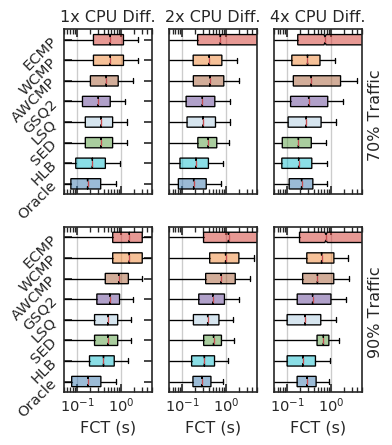

In [329]:
methods2plot = ['oracle', 'hlb-ada', 'sed', 'lsq', 'gsq2', 'active-wcmp', 'weight', 'ecmp']
r = np.arange(len(methods2plot))

fig, axs = plt.subplots(2, 3, figsize=(4, 5), dpi=96, sharex=True, sharey=False)

for j, rate in enumerate([0.7, 0.9]):
    for i, (setup, xlim, title) in enumerate(zip(setups[:3], [[5e-2, 5]]*3, ['{}x CPU Diff.'.format(i) for i in [1, 2, 4]])):

        bplot = axs[j][i].boxplot([fct_all[setup][m][rate] for m in methods2plot], 
                positions=r, showfliers=False, notch=True, patch_artist=True, vert=False)


        for patch, color in zip(bplot['boxes'], [COLORS_DICT[m] for m in methods2plot]):
            color = [int(color.strip('#')[i:i+2], 16)/255 for i in (0, 2, 4)]
            color.append(0.5)
            patch.set_facecolor(color)
        plt.setp(bplot['medians'], color='r')
    #         patch.set_facecolor('w')
    #     plt.plot(range(-2, 5), [2.]*len(range(-2, 5)), '--', label='SED/WCMP Weights Ratio')

    #     plt.xlim([-0.5, 3.5])
    #     plt.ylim([0.75, 2.4])
        #     plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
        #                ncol=4, mode="expand", borderaxespad=0.)
        if i == 0:
            plt.sca(axs[j][i])
            plt.yticks(r, [method_mapper[m] for m in methods2plot], rotation=45)
        else:
            plt.sca(axs[j][i])
            plt.yticks([], [])
        if i == 2:
            plt.text(7, 5, '{:.0%} Traffic'.format(rate), fontsize=12, rotation=90)

        if j == 0:
            axs[j][i].set_title(title)
        else:
            axs[j][i].set_xlabel('FCT (s)')
            plt.sca(axs[j][i])
            plt.xticks([0.1, 1.0, 5], [0.1, 1, 5])

    #     plt.xlabel('AS Capacity Ratio')
    #     plt.text(2, 0.65, r'$\cos(2 \pi t) \exp(-t)$', fontdict=font)
        axs[j][i].set_xscale('log')
        axs[j][i].set_xlim(xlim)
    #     plt.legend()
        axs[j][i].grid(axis='y')
    #     plt.title('{:.0%} Expected Utilization'.format(rate))
    #     plt.show()

fig.savefig(os.path.join(fig_dir, 'capacity-ratio-fct.pdf'), bbox_inches='tight', transparent=True)

## Count #flow to each group of ASes

In [ ]:
ratio_str = r"$\frac{\overline{w}_{2CPU}}{\overline{w}_{1CPU}}$"
df_dict = {
    ratio_str: [],
    "Ratio Type": [],
    "AS Capacity Ratio": [],
    "Traffic Rate": [],
}

In [ ]:
metric_all = {}
methods = ['hlb-ada']
n_404 = 0
for setup in setups:
    metric_all[setup] = {}
    for method in methods:
        print(method)
        metric_all[setup][method] = {}
        folder_ = os.path.join(root_dir, setup, method)
        rates_ = !ls $folder_
        rates_ = [float(r.lstrip('rate')) for r in rates_]
        for rate in rates_:
            metric_all[setup][method][rate] = {}
            folder_rate = os.path.join(folder_, 'rate{:.3f}'.format(rate))
            episodes = !ls $folder_rate
            episodes = [i.rstrip('.json') for i in episodes if '.json' in i]
            for episode in episodes:
                if len(episodes) == 0:
                    print("No episode in", folder_rate)
                filename = os.path.join(folder_rate, '{}.json'.format(episode))
                metric_all[setup][method][rate][episode] = {}
                try:
                    f = json_read_file(filename)
                    for metric in metrics:
                        metric_all[setup][method][rate][episode][metric] = f['clt0'][metric][int(len(f['clt0'][metric])*0.25):int(len(f['clt0'][metric])*0.75)]
                except FileNotFoundError:
                    n_404 += 1
                    print(">> (total {}) Not found:".format(n_404), filename)
                    for metric in metrics:
                        metric_all[setup][method][rate][episode][metric] = np.nan
                except ValueError:  # includes simplejson.decoder.JSONDecodeError
                    print("Json Decoded Error: {}".format(filename))

In [ ]:
for as_ratio, setup in zip(['1x', '2x', '4x'], setups):
    for rate in rates_:
        for episode in episodes:
            for method in methods:
                v = np.array(metric_all[setup][method][rate][episode][metric])
                df_dict[ratio_str] += list((v[:, :64].mean(axis=1))/(v[:, 64:].mean(axis=1)))
                df_dict["Ratio Type"] += ["{} Queue Len.".format(method_mapper[method])]*v.shape[0]
                df_dict["AS Capacity Ratio"] += [as_ratio]*v.shape[0]
                df_dict["Traffic Rate"] += [rate]*v.shape[0]        
df = pd.DataFrame.from_dict(df_dict)

In [ ]:
df_n_flow = {
    ratio_str: [],
    "Ratio Type": [],
    "AS Capacity Ratio": [],
    "Traffic Rate": [],
}

In [ ]:
weights = {}
rates = [0.7, 0.9]
episodes = range(5)
for method in ['oracle', 'hlb-ada']:
    for as_ratio, setup in zip(['1x', '2x', '4x'], setups):
        for rate in rates:
            for ep in episodes:
                filename = os.path.join('../../data/simulation/dev-compare-as-variance/{}/{}/rate{:.3f}/ep{}.json'.format(setup, method, rate, ep))
                lines = read_file(filename)
                lines = lines[int(0.25*len(lines)):int(0.75*len(lines))]
                n_2cpu, n_1cpu = 0, 0
                for l in lines:
                    as_id = int(l.split('->')[-2].split('as')[1].split('[')[0])
                    if as_id < 64: n_2cpu += 1
                    else: n_1cpu += 1
                df_n_flow[ratio_str].append(n_2cpu/n_1cpu)
                df_n_flow['Ratio Type'].append('{} # Received Flows'.format(method_mapper[method]))
                df_n_flow['AS Capacity Ratio'].append(as_ratio)
                df_n_flow['Traffic Rate'].append(rate)
df_n_flow = pd.DataFrame.from_dict(df_n_flow)
df_ratio = pd.concat([df.loc[df['Ratio Type'] == 'HLB-ada Weights'], df_n_flow])

In [ ]:
r = np.array(range(len(setups)))
barWidth = 0.6/2
alpha = 0.7
method = 'hlb-ada'
f, axs = plt.subplots(2, 1, figsize=(2.5, 5), dpi=96)

for i, rate in enumerate([0.7, 0.9]):

    ax = axs[i]
    
    bp = ax.boxplot([df_ratio.loc[(df_ratio['Ratio Type'] == 'HLB-ada Weights') & (df_ratio['AS Capacity Ratio'] == as_capacity_ratio)][ratio_str.replace('w', 'Value')].values for as_capacity_ratio in ['1x', '2x', '4x']],
                    positions=r, showfliers=False, notch=False, )
    
    l1 = ax.plot(r, [1, 2, 4], '--', label='#CPU')
    l2 = ax.plot(r, [df_ratio.loc[(df_ratio['Traffic Rate'] == rate)& (df_ratio['Ratio Type'] == 'SRT # Received Flows') & (df_ratio['AS Capacity Ratio'] == as_capacity_ratio)][ratio_str.replace('w', 'Value')].values.mean() for as_capacity_ratio in ['1x', '2x', '4x']], '-+', label='SRT #Flows')
    l3 = ax.plot(r, [df_ratio.loc[(df_ratio['Traffic Rate'] == rate) &(df_ratio['Ratio Type'] == 'HLB-ada # Received Flows') & (df_ratio['AS Capacity Ratio'] == as_capacity_ratio)][ratio_str.replace('w', 'Value')].values.mean() for as_capacity_ratio in ['1x', '2x', '4x']], '-x', label='HLB-ada #Flows')

#     plt.sca(axs[i])

#     plt.legend([bp["boxes"][0], l1], ['HLB-ada Weights', '#CPU'], loc='upper left')
    
#     plt.xlim([1e-2, 40])
#     plt.ylim([0.8, 4])
#     plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
#                ncol=4, mode="expand", borderaxespad=0.)
    if i == 1:
        plt.xticks(r, ['1x', '2x', '4x'])
        plt.xlabel('AS Capacity Ratio')
    else:
        axs[i].set_xticks([], [])
        handles, _ = ax.get_legend_handles_labels()
        # manually define a new patch 
        patch = mpatches.Patch(edgecolor='k', facecolor='white', label='HLB-ada Weights')
        # handles is a list, so append manual patch
        handles.append(patch) 
        # plot the legend
        axs[i].legend(handles=handles, bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=1, mode="expand", borderaxespad=0.)
    axs[i].set_ylabel('{} ({:.0%} Traffic)'.format(ratio_str.replace('w', 'Value'), rate))
    axs[i].set_yscale('log', basey=2)
    
    axs[i].grid(axis='x')
    axs[i].set_xlim([-0.3, 2.3])
#     plt.title('{:.0%} Expected Utilization'.format(rate))
filename = 'hlb-weight-capacity.pdf'.format(rate)
f.savefig(os.path.join(fig_dir, filename), transparent=True, bbox_inches='tight')

# Partial Observation

In [330]:
experiment_name = 'po2-reduce'
root_dir = '../../data/simulation/hlb-ton/'+experiment_name # data directory
setups = !ls $root_dir
metrics = ['fct-avg', 'fct-p90']
po2_methods = ['hlb', 'sed', 'gsq', 'lsq', 'oracle']
benchmark_methods = ['wcmp', 'active-wcmp']

In [331]:
fct_all = {}
n_404 = 0
for setup in setups:
    fct_all[setup] = {}
    methods = !ls {root_dir+'/'+setup}
    for method in methods:
        fct_all[setup][method] = {}
        folder_ = os.path.join(root_dir, setup, method)
        rates_ = !ls $folder_
        rates_ = [float(r.lstrip('rate')) for r in rates_]
        for rate in rates_:
            fct_all[setup][method][rate] = []
            folder_rate = os.path.join(folder_, 'rate{:.3f}'.format(rate))
            episodes = !ls $folder_rate
            episodes = [i.rstrip('.json') for i in episodes if '.json' in i]
            for episode in episodes:
                if len(episodes) == 0:
                    print("No episode in", folder_rate)
                filename = os.path.join(folder_rate, '{}.json'.format(episode))
                try:
                    f = json_read_file(filename)
                    fct_all[setup][method][rate] += f['clt0']['all_fct']
                except FileNotFoundError:
                    n_404 += 1
                    print(">> (total {}) Not found:".format(n_404), filename)

In [340]:
methods2plot = [
 'oracle',
 'oracle2',
 'gsq',
 'gsq2',
 'hlb',
 'hlb2',
 'lsq',
 'lsq2',
 'sed',
 'sed2',
 'weight',
 'active-wcmp',
]
COLORS_DICT = {
    'hlb': "#17becf",
    'hlb2': "#17becf",
    'sed': '#559d3f',
    'sed2': '#559d3f',
    'lsq': "#aecde1",
    'lsq2': "#aecde1",
#     'lsq2': "#634295",
    'active-wcmp': "#a65d34",
    'weight': "#ef8532", 
    'ecmp': "#d1342b", 
    'oracle': '#3978af',
    'oracle2': '#3978af',
    'gsq': "#634295",
    'gsq2': "#634295",
    'hlb-ada': "#df3583"
}

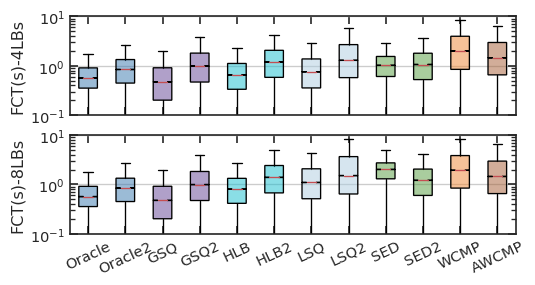

In [344]:
r = np.arange(len(methods2plot))

n_lb = 4
fig, axs = plt.subplots(2, figsize=(6, 3), dpi=96, sharex=True, sharey=True)

for i, setup in enumerate(setups):

    bplot = axs[i].boxplot([fct_all[setup][m][rate] for m in methods2plot], 
            positions=r, showfliers=False, notch=True, patch_artist=True)
    
    
    for patch, color in zip(bplot['boxes'], [COLORS_DICT[m] for m in methods2plot]):
        color = [int(color.strip('#')[i:i+2], 16)/255 for i in (0, 2, 4)]
        color.append(0.5)
        patch.set_facecolor(color)
    plt.setp(bplot['medians'], color='r')
#         patch.set_facecolor('w')
#     plt.plot(range(-2, 5), [2.]*len(range(-2, 5)), '--', label='SED/WCMP Weights Ratio')

#     plt.xlim([-0.5, 3.5])
#     plt.ylim([0.75, 2.4])
    #     plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
    #                ncol=4, mode="expand", borderaxespad=0.)
    if i > 0:
        plt.xticks(r, [method_mapper[m] for m in methods2plot], rotation=25)

#     plt.xlabel('AS Capacity Ratio')
    axs[i].set_ylabel('FCT(s)-{}LBs'.format(n_lb))
    axs[i].set_yscale('log')
    axs[i].set_ylim([1e-1, 10])
#     plt.legend()
    axs[i].grid(axis='x')
#     plt.title('{:.0%} Expected Utilization'.format(rate))
#     plt.show()
    
    n_lb += 4

In [345]:
fig.savefig(os.path.join(fig_dir, 'po2.pdf'), bbox_inches='tight', transparent=True)

## Check Weights and Score Ratio

In [ ]:
root_dir = '../../data/simulation/dev-po2'
setups = !ls $root_dir

In [ ]:
weights = {}
# method = 'hlb'
for method in ['hlb']:
    weights[method] = {}
    for i, setup in enumerate(setups):
        weights[method][setup] = {}
        if method == 'sed':
            for rate in rates_:
                weights[method][setup][rate] = np.power(2, i)
        else:
            folder_ = os.path.join(root_dir, setup, method)
            rates_ = !ls $folder_
            rates_ = [float(r.lstrip('rate')) for r in rates_]
            for rate in rates_:
                folder_rate = os.path.join(folder_, 'rate{:.3f}'.format(rate))
                filename = os.path.join(folder_rate, 'test.log')
                lines = read_file(filename)
                weights_now = []
                i = 0
                while i < len(lines):
                    l = lines[i]
                    if 'new weights' in l:
                        new_weight = []
                        l = l.split('new weights')[-1]
                        while ']' not in l:
                            new_weight += [float(w) for w in l.split('[')[-1].lstrip(' ').rstrip(' ').split(' ') if w is not '']
                            i += 1
                            l = lines[i]
                        new_weight += [float(w) for w in l.lstrip(' ').rstrip(']').split(' ') if w is not '']
    #                     if method == 'hlb-ada':
    #                         new_weight = softmax(-np.array(new_weight))
                        weights_now.append(new_weight[int(0.1*len(new_weight)):int(0.9*len(new_weight))])
                        i += 1
                    else:
                        i += 1

                weights[method][setup][rate] = weights_now

In [ ]:
df_dict = {
    '# LB': [],
    'HLB Weights Ratio': [],
    'Workload': [],
}
for n_lb in [4,8]:
    setup = '{}lb-128as-1worker-1stage-exp-0.50cpumu'.format(n_lb)
    for rate in [0.7, 0.9]:
        utilization = "{:.0%}".format(rate)
        weights_ratio = list((np.array(weights[method][setup][rate])[:, :64].mean(axis=1) / np.array(weights[method][setup][rate])[:, 64:].mean(axis=1))[-int(np.array(weights[method][setup][rate]).shape[0]/2):int(np.array(weights[method][setup][rate]).shape[0]*0.9)])
        df_dict['HLB Weights Ratio'] += weights_ratio
        df_dict['# LB'] += [n_lb]*len(weights_ratio)
        df_dict['Workload'] += [utilization]*len(weights_ratio)
df_weight = pd.DataFrame.from_dict(df_dict)

In [ ]:
score_all = {}
for setup in setups:
    score_all[setup] = {}
    
    for method in ['sed', 'hlb']:
        score_all[setup][method] = {}
        for rate in [0.7, 0.9]:
            folder2check = '../../data/simulation/dev-po2/{}/{}/rate{:.3f}/'.format(setup, method, rate)
            lines = read_file(os.path.join(folder2check, 'test.log'))
            log_lines = []
            for l in lines:
                if 'end of episode' in l: break
                log_lines.append(l)
            scores = [[float(f) for f in l.strip('score: [').strip(']').split(',')] for l in log_lines if 'score: [' in l]
            n_flow = [[float(f) for f in l.strip('n_flow: [').strip(']').split(',')] for l in log_lines if 'n_flow: [' in l]
            t_remain = [[float(f) for f in l.strip('t_remain: [').strip(']').split(',')] for l in log_lines if 't_remain: [' in l]
            score_all[setup][method][rate] = {
                'score': np.array(scores[int(0.1*len(scores)):int(0.9*len(scores))]),
                'qlen': np.array(n_flow[int(0.1*len(scores)):int(0.9*len(scores))]),
                't_remain': np.array(t_remain[int(0.1*len(scores)):int(0.9*len(scores))]),
            }b
            rate = 0.9
qlen_ratio = {
    'Queue Length Ratio': [],
    'Expected Workload': [],
    '# LB': [],
    'Method': [],
}
for method in ['sed', 'hlb']:
    for n_lb in [4, 8]:
        setup = '{}lb-128as-1worker-1stage-exp-0.50cpumu'.format(n_lb)
        for rate in [0.7, 0.9]:
            weights_ratio = list(score_all[setup][method][rate]['qlen'][:, :64].mean(axis=1) / score_all[setup][method][rate]['qlen'][:, 64:].mean(axis=1))
            qlen_ratio['Queue Length Ratio'] += weights_ratio
            qlen_ratio['Expected Workload'] += ['{:.0%}'.format(rate)]*len(weights_ratio)
            qlen_ratio['# LB'] += [n_lb]*len(weights_ratio)
            qlen_ratio['Method'] += [method_mapper[method]]*len(weights_ratio)
qlen_df = pd.DataFrame.from_dict(qlen_ratio)

In [ ]:
f, axs = plt.subplots(1, 3, figsize=(6,2), dpi=96)
plt.sca(axs[0])
ax = sns.boxplot(x="Workload", y="HLB Weights Ratio", hue="# LB",
                  data=df_weight, palette="Set3", orient='v', showfliers=False)
plt.ylim(0.8, 2.6)
# plt.xlabel('Workload')
plt.legend().set_visible(False)
plt.title('LB Method - HLB')
plt.ylabel('AS Weights Ratio')

plt.sca(axs[1])
ax = sns.boxplot(x="Method", y="Queue Length Ratio", hue="# LB",
                  data=qlen_df.loc[qlen_df['Expected Workload'] == '70%'], palette="Set3", orient='v', showfliers=False)
plt.ylim(1.8, 600)
plt.yscale('log')
axs[1].yaxis.tick_right()
plt.yticks(rotation=90)
# axs[1].yaxis.set_label_position("right")

# plt.xscale('log')
plt.legend(title='# LB')
plt.title('70% Workload')


plt.sca(axs[2])
ax = sns.boxplot(x="Method", y="Queue Length Ratio", hue="# LB",
                  data=qlen_df.loc[qlen_df['Expected Workload'] == '90%'], palette="Set3", orient='v', showfliers=False)
plt.ylim(1.8, 10)
axs[2].yaxis.tick_right()
# axs[1].yaxis.set_label_position("right")

# plt.xscale('log')
plt.ylabel('')
plt.legend().set_visible(False)
plt.title('90% Workload')


# plt.legend(title='# LB', bbox_to_anchor=(1.02, 0.26, .352, 1.), loc='lower left',
#            ncol=1, mode="expand", borderaxespad=0.)

filename = 'po2-box.pdf'
f.savefig(os.path.join(fig_dir, filename), transparent=True, bbox_inches='tight')

## Compare Score and Correlation

In [ ]:
min_max_scale = lambda x: (x - min(x))/(max(x) - min(x) + 1e-6)

In [ ]:
norm_fn = min_max_scale
df_score = {}
for n_lb in [4, 8]:
    df_score[n_lb] = {}
    setup = '{}lb-128as-1worker-1stage-exp-0.50cpumu'.format(n_lb)
    for method in ['sed', 'hlb']:
        df_score[n_lb][method] = {}
        for rate in [0.7, 0.9]:
            print(setup, method, rate)
            
            # df0
            score2compare = []
            t_norm = []
            cpu_list = []
            # df1
            qlen = []
            t = []
            n_cpu = []
            
            data = score_all[setup][method][rate]
            t_remain = data['t_remain']
            scores = data['score']
            n_flow = data['qlen']
            for i in range(int(0.1*len(scores)), int(0.9*len(scores))):
                # df0 - queue length vs. score
                score2compare += list(norm_fn(scores[i]))
                t_norm += list(norm_fn(t_remain[i]))
                cpu_list += [2]*int(len(scores[i])/2)
                cpu_list += [1]*int(len(scores[i])/2)
                
                # df1 - queue length vs. t_remain
                min_score = min(scores[i])
                min_ids = [k for k, v in enumerate(scores[i]) if v == min_score]
                ii = random.choice(min_ids)
                qlen.append(norm_fn(n_flow[i])[ii])
                t.append(norm_fn(t_remain[i])[ii])
                if ii < len(scores[i])/2: n_cpu.append(2)
                else: n_cpu.append(1)
            df0 = {
                'Score': score2compare,
                'Normalized T Remain': t_norm,
                '#CPU': cpu_list
            }
            df1 = {
                'Actual Queue Len.': qlen,
                'Normalized T Remain': t,
                '#CPU': n_cpu
            }
            df_score[n_lb][method][rate] = {
                'score': pd.DataFrame.from_dict(df0),
                't_remain': pd.DataFrame.from_dict(df1),
            }

In [ ]:
df2plot = df_score[8]['hlb'][0.9]['t_remain'].sample(500)
sns.set(style="ticks", font_scale=1.5)
sns.set_style({"xtick.direction": "in","ytick.direction": "in","xtick.top":True,"ytick.right":True,"axes.grid":True})

f = sns.jointplot(
    data=df2plot,
    x="Score", y="Normalized T Remain", hue="#CPU",
    kind="kde",
    palette='tab10',
)
f.fig.suptitle(r'HLB Score Computed as $\frac{\tilde{l}_{ij} + 1}{\tilde{w}_{ij}}$', y=1.05)
plt.tight_layout()

plt.show()
f.savefig(os.path.join(fig_dir, '8lb-hlb-90-score.pdf'))

# Multi-Stage

In [346]:
experiment_name = 'multi-stage-reduce'
root_dir = '../../data/simulation/hlb-ton/'+experiment_name # data directory
setups = !ls $root_dir
metrics = ['all_fct', 'fct-p99']
methods = ['oracle', 'hlb-ada', 'sed', 'lsq', 'gsq2', 'active-wcmp', 'weight', 'ecmp']

In [347]:
fct_all = {}
for setup in setups:
    print("====== setup: {} ======".format(setup))
    fct_all[setup] = {}
    methods = !ls {root_dir+'/'+setup}
    for method in methods:
#     for method in ['hlb-ada', 'hlb', 'hlb-ada-backup', 'sed']:
        print("=== method:", method, "===")
        fct_all[setup][method] = {}
        folder_ = os.path.join(root_dir, setup, method)
        rates_ = !ls $folder_
        rates_ = [float(r.lstrip('rate')) for r in rates_]
        for rate in rates_:
            print(">> rate:", rate)
            fct_all[setup][method][rate] = []
            folder_rate = os.path.join(folder_, 'rate{:.3f}'.format(rate))
            episodes = !ls $folder_rate
            episodes = [i.rstrip('.json') for i in episodes if '.json' in i]
            for episode in episodes:
                if len(episodes) == 0:
                    print("No episode in", folder_rate)
                filename = os.path.join(folder_rate, '{}.json'.format(episode))
                try:
                    f = json_read_file(filename)
                    fct_all[setup][method][rate] += f['clt0']['all_fct']
                except FileNotFoundError:
                    n_404 += 1
                    print(">> (total {}) Not found:".format(n_404), filename)

====== setup: 4lb-128as-1worker-1stage-exp-1.00cpumu ======
=== method: active-wcmp ===
>> rate: 0.7
>> rate: 0.9
=== method: ecmp ===
>> rate: 0.7
>> rate: 0.9
=== method: gsq ===
>> rate: 0.7
>> rate: 0.9
=== method: gsq2 ===
>> rate: 0.7
>> rate: 0.9
=== method: hlb ===
>> rate: 0.7
>> rate: 0.9
=== method: hlb-ada ===
>> rate: 0.7
>> rate: 0.9
=== method: hlb-ada-backup ===
>> rate: 0.7
>> rate: 0.9
=== method: lsq ===
>> rate: 0.7
>> rate: 0.9
=== method: lsq2 ===
>> rate: 0.7
>> rate: 0.9
=== method: oracle ===
>> rate: 0.7
>> rate: 0.9
=== method: sed ===
>> rate: 0.7
>> rate: 0.9
=== method: weight ===
>> rate: 0.7
>> rate: 0.9
====== setup: 4lb-128as-1worker-3stage-exp-0.25cpumu-0.75iomu ======
=== method: active-wcmp ===
>> rate: 0.7
>> rate: 0.9
=== method: ecmp ===
>> rate: 0.7
>> rate: 0.9
=== method: gsq ===
>> rate: 0.7
>> rate: 0.9
=== method: gsq2 ===
>> rate: 0.7
>> rate: 0.9
=== method: hlb ===
>> rate: 0.7
>> rate: 0.9
=== method: hlb-ada ===
>> rate: 0.7
>> rate: 0

In [350]:
COLORS_DICT = {
    'hlb': "#df3583",
    'hlb2': "#df3583",
    'sed': '#559d3f',
    'sed2': '#559d3f',
    'lsq': "#aecde1",
    'lsq2': "#aecde1",
#     'lsq2': "#634295",
    'active-wcmp': "#a65d34",
    'weight': "#ef8532", 
    'ecmp': "#d1342b", 
    'oracle': '#3978af',
    'oracle2': '#3978af',
    'gsq': "#634295",
    'gsq2': "#634295",
    'hlb-ada': "#17becf",
}

In [351]:
setups = ['4lb-128as-1worker-1stage-exp-1.00cpumu',
 '4lb-128as-1worker-3stage-exp-0.75cpumu-0.25iomu',
 '4lb-128as-1worker-3stage-exp-0.50cpumu-0.50iomu',
 '4lb-128as-1worker-3stage-exp-0.25cpumu-0.75iomu']
methods2plot = ['oracle', 'hlb-ada', 'sed', 'lsq', 'gsq2', 'active-wcmp', 'weight', 'ecmp']

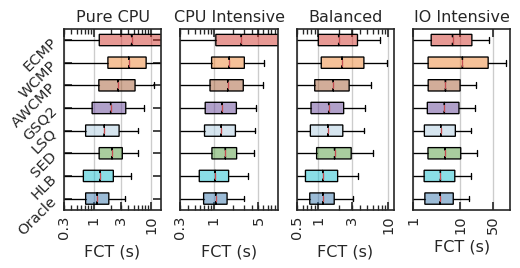

In [352]:
# barWidth = 0.8
# alpha = 0.9
rate = 0.9
r = np.arange(len(methods2plot))

fig, axs = plt.subplots(1, 4, figsize=(6, 2.5), dpi=96, sharex=False, sharey=False)

for i, (setup, xlim, title, xticks) in enumerate(zip(setups, [[0.3, 15], [0.3, 10], [0.5, 12], [1, 120]]*4, ['Pure CPU', 'CPU Intensive', 'Balanced', 'IO Intensive'], 
                                                     [[[0.3, 1., 3, 10], [0.3, 1, 3, 10]], 
                                                      [[0.3, 1., 5], [0.3, 1, 5]], 
                                                      [[0.5, 1., 3, 10], [0.5, 1, 3, 10]], 
                                                      [[1, 10., 50], [1, 10, 50]]])):

    bplot = axs[i].boxplot([fct_all[setup][m][rate] for m in methods2plot], 
            positions=r, showfliers=False, notch=True, patch_artist=True, vert=False)
    
    
    for patch, color in zip(bplot['boxes'], [COLORS_DICT[m] for m in methods2plot]):
        color = [int(color.strip('#')[i:i+2], 16)/255 for i in (0, 2, 4)]
        color.append(0.5)
        patch.set_facecolor(color)
    plt.setp(bplot['medians'], color='r')
#         patch.set_facecolor('w')
#     plt.plot(range(-2, 5), [2.]*len(range(-2, 5)), '--', label='SED/WCMP Weights Ratio')

#     plt.xlim([-0.5, 3.5])
#     plt.ylim([0.75, 2.4])
    #     plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
    #                ncol=4, mode="expand", borderaxespad=0.)
    if i == 0:
        plt.sca(axs[i])
        plt.yticks(r, [method_mapper[m] for m in methods2plot], rotation=45)
    else:
        plt.sca(axs[i])
        plt.yticks([], [])

#     plt.xlabel('AS Capacity Ratio')
    axs[i].set_xlabel('FCT (s)')
#     plt.text(2, 0.65, r'$\cos(2 \pi t) \exp(-t)$', fontdict=font)
    axs[i].set_title(title)
    axs[i].set_xscale('log')
    axs[i].set_xlim(xlim)
    plt.xticks(*xticks, rotation=90)


#     plt.legend()
    axs[i].grid(axis='y')
#     plt.title('{:.0%} Expected Utilization'.format(rate))
#     plt.show()

fig.savefig(os.path.join(fig_dir, 'multi-stage-90.pdf'), bbox_inches='tight', transparent=True)

## Check weights

In [353]:
weights = {}
method = 'hlb-ada'
for setup in setups:
    weights[setup] = {}
    folder_ = os.path.join(root_dir, setup, method)
    rates_ = !ls $folder_
    rates_ = [float(r.lstrip('rate')) for r in rates_]
    for rate in rates_:
        folder_rate = os.path.join(folder_, 'rate{:.3f}'.format(rate))
        filename = os.path.join(folder_rate, 'test.log')
        lines = read_file(filename)
        weights_now = []
        i = 0
        while i < len(lines):
            l = lines[i]
            if 'new weights' in l:
                new_weight = []
                l = l.split('new weights')[-1]
                while ']' not in l:
                    new_weight += [float(w) for w in l.split('[')[-1].lstrip(' ').rstrip(' ').split(' ') if w is not '']
                    i += 1
                    l = lines[i]
                new_weight += [float(w) for w in l.lstrip(' ').rstrip(']').split(' ') if w is not '']
#                     if method == 'hlb-ada':
#                     new_weight = softmax(-np.array(new_weight))
                weights_now.append(new_weight)
                i += 1
            else:
                i += 1

        weights[setup][rate] = weights_now

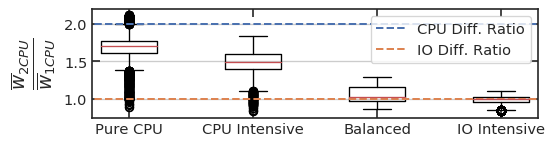

In [355]:
fig = plt.figure(figsize=(6, 1.5), dpi=96)
rate = 0.9

r = np.array(range(len(setups)))
bplot = plt.boxplot([(np.array(weights[setup][rate])[:, :64].mean(axis=1) / np.array(weights[setup][rate])[:, 64:].mean(axis=1))[-int(np.array(weights[setup][rate]).shape[0]/2):] for setup in setups], 
            positions=r)
plt.plot(range(-2, 5), [2.]*len(range(-2, 5)), '--', label='CPU Diff. Ratio')
plt.plot(range(-2, 5), [1.]*len(range(-2, 5)), '--', label='IO Diff. Ratio')


plt.ylim([0.75, 2.2])
#     plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
#                ncol=4, mode="expand", borderaxespad=0.)
plt.setp(bplot['medians'], color='r')
plt.xticks(r, ['Pure CPU', 'CPU Intensive', 'Balanced', 'IO Intensive'])
0821plt.ylabel(r'$\frac{\overline{w}_{2CPU}}{\overline{w}_{1CPU}}$', fontsize=20)
plt.legend()
plt.xlim([-0.3, 3.3])
plt.grid(axis='x')
# plt.title('{:.0%} Expected Utilization'.format(rate))
plt.show()

#         plt.xlabel("$\mu$ (s)")


fig.savefig(os.path.join(fig_dir, 'multi-stage-weight.pdf'), bbox_inches='tight', transparent=True)

# Input FCT

In [358]:
experiment_name = 'input-fct-lognormal-reduce'
root_dir = '../../data/simulation/hlb-ton/'+experiment_name # data directory
setups = !ls $root_dir
metrics = ['all_fct', 'fct-p99']
methods2plot = ['oracle', 'hlb-ada', 'hlb', 'sed', 'lsq', 'gsq2', 'active-wcmp', 'weight', 'ecmp']

In [357]:
fct_all = {}
for setup in setups:
    print("====== setup: {} ======".format(setup))
    fct_all[setup] = {}
    methods = !ls {root_dir+'/'+setup}
    for method in methods:
#     for method in ['hlb-ada', 'hlb', 'hlb-ada-backup', 'sed']:
        print("=== method:", method, "===")
        fct_all[setup][method] = {}
        folder_ = os.path.join(root_dir, setup, method)
        rates_ = !ls $folder_
        rates_ = [float(r.lstrip('rate')) for r in rates_]
        for rate in rates_:
            print(">> rate:", rate)
            fct_all[setup][method][rate] = []
            folder_rate = os.path.join(folder_, 'rate{:.3f}'.format(rate))
            episodes = !ls $folder_rate
            episodes = [i.rstrip('.json') for i in episodes if '.json' in i]
            for episode in episodes:
                if len(episodes) == 0:
                    print("No episode in", folder_rate)
                filename = os.path.join(folder_rate, '{}.json'.format(episode))
                try:
                    f = json_read_file(filename)
                    fct_all[setup][method][rate] += f['clt0']['all_fct']
                except FileNotFoundError:
                    n_404 += 1
                    print(">> (total {}) Not found:".format(n_404), filename)

====== setup: 4lb-128as-1worker-1stage-exp-0.50mu-0.50std ======
=== method: active-wcmp ===
>> rate: 0.9
=== method: ecmp ===
>> rate: 0.9
=== method: gsq2 ===
>> rate: 0.9
=== method: hlb ===
>> rate: 0.9
=== method: hlb-ada ===
>> rate: 0.9
=== method: lsq ===
>> rate: 0.9
=== method: oracle ===
>> rate: 0.9
=== method: sed ===
>> rate: 0.9
=== method: weight ===
>> rate: 0.9
====== setup: 4lb-128as-1worker-1stage-exp-0.50mu-1.00std ======
=== method: active-wcmp ===
>> rate: 0.9
=== method: ecmp ===
>> rate: 0.9
=== method: gsq2 ===
>> rate: 0.9
=== method: hlb ===
>> rate: 0.9
=== method: hlb-ada ===
>> rate: 0.9
=== method: lsq ===
>> rate: 0.9
=== method: oracle ===
>> rate: 0.9
=== method: sed ===
>> rate: 0.9
=== method: weight ===
>> rate: 0.9
====== setup: 4lb-128as-1worker-1stage-exp-1.00mu-0.50std ======
=== method: active-wcmp ===
>> rate: 0.9
=== method: ecmp ===
>> rate: 0.9
=== method: gsq2 ===
>> rate: 0.9
=== method: hlb ===
>> rate: 0.9
=== method: hlb-ada ===
>> ra

In [359]:
methods2plot = ['oracle', 'hlb-ada', 'hlb', 'sed', 'lsq', 'gsq2', 'active-wcmp', 'weight', 'ecmp']

In [367]:
method_mapper = {
    'ecmp': 'ECMP',
    'weight': 'WCMP',
    'lsq': 'LSQ',
    'lsq2': 'LSQ2',
    'sed': 'SED',
    'sed2': 'SED2',
    'gsq': 'GSQ',
    'gsq2': 'GSQ2',
    'oracle': 'Oracle',
    'oracle2': 'Oracle2',
    'active-wcmp': 'AWCMP',
    'hlb': 'HLB-FIX',
    'hlb2': 'HLB2',
    'hlb-ada': 'HLB',
}

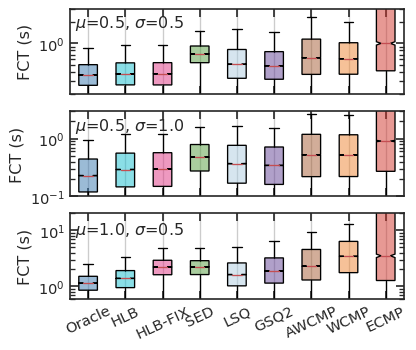

In [369]:
# barWidth = 0.8
# alpha = 0.9
rate = 0.9
r = np.arange(len(methods2plot))

n_lb = 4
fig, axs = plt.subplots(3, figsize=(4.5, 4), dpi=96, sharex=True, sharey=False)

for i, (setup, ylim, title) in enumerate(zip(setups[:3], [[.2, 3], [.1, 3], [.6, 20]], [r'$\mu$={:.1f}, $\sigma$={:.1f}'.format(mu, std) for mu, std in [(0.5, 0.5), (0.5, 1.0), (1., 0.5)]])):

    bplot = axs[i].boxplot([fct_all[setup][m][rate] for m in methods2plot], 
            positions=r, showfliers=False, notch=True, patch_artist=True)
    
    
    for patch, color in zip(bplot['boxes'], [COLORS_DICT[m] for m in methods2plot]):
        color = [int(color.strip('#')[i:i+2], 16)/255 for i in (0, 2, 4)]
        color.append(0.5)
        patch.set_facecolor(color)
    plt.setp(bplot['medians'], color='r')
#         patch.set_facecolor('w')
#     plt.plot(range(-2, 5), [2.]*len(range(-2, 5)), '--', label='SED/WCMP Weights Ratio')

#     plt.xlim([-0.5, 3.5])
#     plt.ylim([0.75, 2.4])
    #     plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
    #                ncol=4, mode="expand", borderaxespad=0.)
    if i == len(setups)-1:
        plt.xticks(r, [method_mapper[m] for m in methods2plot], rotation=25)

#     plt.xlabel('AS Capacity Ratio')
    axs[i].set_ylabel('FCT (s)')
#     plt.text(2, 0.65, r'$\cos(2 \pi t) \exp(-t)$', fontdict=font)
    if i == 2:
        axs[i].set_title(title, x=0.18, y=.98, pad=-14)
    else:
        axs[i].set_title(title, x=0.18, y=1.0, pad=-14)
    axs[i].set_yscale('log')
    axs[i].set_ylim(ylim)
#     plt.legend()
    axs[i].grid(axis='y')
#     plt.title('{:.0%} Expected Utilization'.format(rate))
#     plt.show()
fig.savefig(os.path.join(fig_dir, 'input-lognormal.pdf'), bbox_inches='tight', transparent=True)

## Plot Kalman Gain

In [193]:
experiment_name = 'input-fct-lognormal-reduce'
root_dir = '../../data/simulation/'+experiment_name
rate = 0.9

In [194]:
ks = {}
for setup in setups[:3]:
    ks[setup] = {}
    for method in ['hlb', 'hlb-ada']:
        print("=== method:", method, "===")
        folder_ = os.path.join(root_dir, setup, method)
        folder_rate = os.path.join(folder_, 'rate{:.3f}'.format(rate))
        filename = os.path.join(folder_rate, 'test.log')
        f = read_file(filename)
        lines = []
        n_noflow = 0
        for l in f:
            if 'no flow registered' in l:
                n_noflow += 1
                if n_noflow > 1: break
            lines.append(l)
        k_lines = [l for l in lines if 'Kalman Gain' in l]
        ks[setup][method] = [float(l.split('= ')[-1]) for l in k_lines]

=== method: hlb ===
=== method: hlb-ada ===
=== method: hlb ===
=== method: hlb-ada ===
=== method: hlb ===
=== method: hlb-ada ===


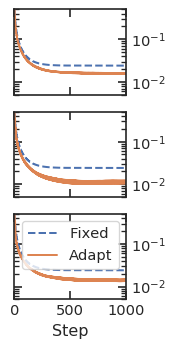

In [201]:
fig, axs = plt.subplots(3, figsize=(1.5,4), dpi=96, sharex=True)

for i, setup in enumerate(setups[:3]):
    for method, label in zip(['hlb', 'hlb-ada'], ['Fixed', 'Adapt']):
        if method =='hlb': linestyle= '--'
        else: linestyle = '-'
        axs[i].plot(ks[setup][method], label=label, linestyle=linestyle)

    # plt.legend(loc='upper left')
#     plt.text(520., 0.04, 'Kalman Gain', rotation=90, fontsize=12)
    axs[i].set_yscale('log')
    axs[i].set_ylim([5e-3, 0.5])
    axs[i].grid()
    axs[i].set_xlim([0, 1000])
    axs[i].yaxis.tick_right()
    axs[i].yaxis.set_ticks_position('both')
    # plt.title('{}-{} FCT by CPU'.format(target_trace.rstrip('.csv'), method))
# axs[0].legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
#    ncol=1, mode="expand", borderaxespad=0.)

axs[i].legend()



axs[i].set_xlabel('Step', fontsize=12)
fig.savefig(os.path.join(fig_dir, 'kalman_gain.pdf'), bbox_inches='tight', transparent=True)

# Compare number of buckets

In [243]:
experiment_name = 'hlb-ton/dev-bucket-reduce'
root_dir = '../../data/simulation/'+experiment_name
setups = !ls $root_dir
methods = !ls $root_dir/{setups[0]}
n_buckets = np.sort(list(set([int(m.split('-')[-1].rstrip('bucket')) for m in methods if 'bucket' in m])))
rate = 0.9

In [244]:
metrics = ['fct-avg', 'fct-p90', 'fct-p99']

In [245]:
metric_all = {}
n_404 = 0
for setup in setups:
    metric_all[setup] = {}
    methods = !ls {root_dir+'/'+setup}
    for method in methods:
        if method == 'backup': continue
        metric_all[setup][method] = {}
        folder_ = os.path.join(root_dir, setup, method)
        rates_ = !ls $folder_
        rates_ = [float(r.lstrip('rate')) for r in rates_]
        for rate in rates_:
            metric_all[setup][method][rate] = {}
            folder_rate = os.path.join(folder_, 'rate{:.3f}'.format(rate))
            episodes = !ls $folder_rate
            episodes = [i.rstrip('.json') for i in episodes if '.json' in i]
            for episode in episodes:
                if len(episodes) == 0:
                    print("No episode in", folder_rate)
                filename = os.path.join(folder_rate, '{}.json'.format(episode))
                metric_all[setup][method][rate][episode] = {}
                try:
                    f = json_read_file(filename)
                    for metric in metrics:
                        metric_all[setup][method][rate][episode][metric] = f['clt0'][metric]
                    metric_all[setup][method][rate][episode]['n_untracked'] = [f[lb]['n_untracked'] for lb in [k for k in f.keys() if 'lb' in k]]
                except FileNotFoundError:
                    n_404 += 1
                    print(">> (total {}) Not found:".format(n_404), filename)
                    for metric in metrics:
                        metric_all[setup][method][rate][episode][metric] = np.nan

In [246]:
bucket_methods = ['lsq', 'sed', 'hlb-ada']
other_methods = ['oracle']

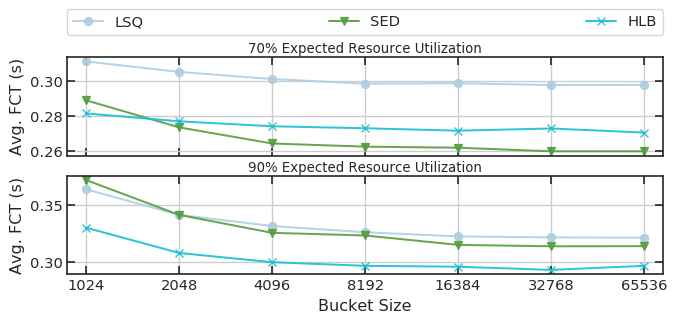

In [247]:
sns.set(style="ticks")
sns.set_style({"xtick.direction": "in","ytick.direction": "in","xtick.top":True,"ytick.right":True,"axes.grid":True})

df_dict = {
    'Avg. FCT (s)': [],
    'Bucket Size': [],
    '# Untracked': [], 
    'LB Method': [],
    'Traffic Rate': [],
}
fig, axs = plt.subplots(2, figsize=(8, 3), dpi=96, sharex=True, sharey=False)
metric = 'fct-avg'
# fig.suptitle('Avg. FCT (s)'.format(rate), position=(0.04, .65), rotation='vertical')
for i, ylabel, rate, ylim in zip(
    range(2), 
    ['70% Expected Resource Utilization', '90% Expected Resource Utilization'], 
    [0.7, 0.9],
    [None, None],
):
    
    for method in bucket_methods:
        v = [np.mean([metric_all[setup][method+'-{}bucket'.format(n_bucket)][rate]['ep{}'.format(ep)][metric] for ep in range(5)]) for n_bucket in n_buckets]
        color = COLORS_DICT[method]
        marker = MARKER_DICT[method]
        linestyle = LINESTYLE_DICT[method]
        axs[i].plot(range(len(n_buckets)), v, linestyle='-', marker=marker, color=color, label=method_mapper[method], alpha=0.9)
        for ep in range(5):
            v = [np.mean(metric_all[setup][method+'-{}bucket'.format(n_bucket)][rate]['ep{}'.format(ep)][metric]) for n_bucket in n_buckets]
            df_dict['Avg. FCT (s)'] += v
            df_dict['Bucket Size'] += list(n_buckets)
            v = [np.mean(metric_all[setup][method+'-{}bucket'.format(n_bucket)][rate]['ep{}'.format(ep)]['n_untracked']) for n_bucket in n_buckets]
            df_dict['# Untracked'] += v
            df_dict['LB Method'] += [method_mapper[method]]*len(v)
            df_dict['Traffic Rate'] += [rate]*len(v)
        
#     x = range(-1, len(n_buckets)+1)
#     for method in other_methods:
#         v = [np.mean([metric_all[setup][method][rate]['ep{}'.format(ep)][metric] for ep in range(5)])] * len(x)
#         color = COLORS_DICT[method]
#         marker = MARKER_DICT[method]
#         linestyle = LINESTYLE_DICT[method]
#         axs[i].plot(x, v, linestyle='--', color=color, label=method_mapper[method], alpha=0.9)

    axs[i].set_xlim([-0.2, len(n_buckets)-0.8])
    axs[i].set_ylim(ylim)
    axs[i].grid(True)
    axs[i].set_title(ylabel, fontsize=10, y=0.96)
    axs[i].set_ylabel('Avg. FCT (s)')
    
    if i == 0: axs[i].legend(bbox_to_anchor=(0., 1.22, 1., .102), loc='lower left',
           ncol=3, mode="expand", borderaxespad=0.)
    if i == 1:
        plt.sca(axs[i])
        plt.xticks(range(len(n_buckets)), n_buckets, rotation=0)
        plt.xlabel("Bucket Size")

fig.savefig(os.path.join(fig_dir, 'compare-bucket.pdf'.format(rate)), bbox_inches='tight', transparent=True)

In [248]:
df = pd.DataFrame.from_dict(df_dict)

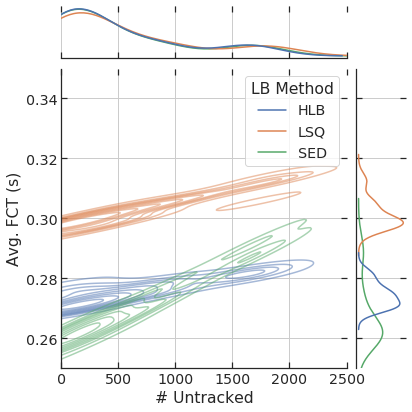

In [249]:
sns.set(style="ticks", font_scale=1.3)
sns.set_style({"xtick.direction": "in","ytick.direction": "in","xtick.top":True,"ytick.right":True,"axes.grid":True})
fig = sns.jointplot(
    data=df.loc[df["Traffic Rate"]==0.7],
    x="# Untracked", y="Avg. FCT (s)", hue="LB Method",
    kind="kde",
    xlim=[0,2500], 
    ylim=[0.25, 0.35],
#     shade=True,
#     thresh=False,
    alpha=.5,
    hue_order=["HLB", "LSQ", "SED"],
)
fig.savefig(os.path.join(fig_dir, 'compare-bucket-corr-70.pdf'.format(rate)), bbox_inches='tight', transparent=True)

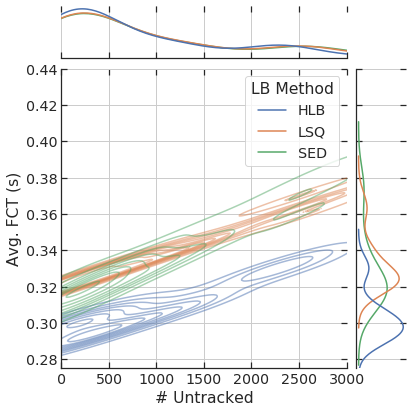

In [222]:
sns.set(style="ticks", font_scale=1.3)
sns.set_style({"xtick.direction": "in","ytick.direction": "in","xtick.top":True,"ytick.right":True,"axes.grid":True})
fig = sns.jointplot(
    data=df.loc[df["Traffic Rate"]==0.9],
    x="# Untracked", y="Avg. FCT (s)", hue="LB Method",
    kind="kde",
#     shade=True,
    alpha=0.5,
    xlim=[0,3000], 
    ylim=[0.275, 0.44],
    hue_order=["HLB", "LSQ", "SED"],
)
fig.savefig(os.path.join(fig_dir, 'compare-bucket-corr-90.pdf'.format(rate)), bbox_inches='tight', transparent=True)

# Compare period

In [3]:
import numpy as np

In [5]:
experiment_name = 'compare-lb-period-reduce'
root_dir = '/home/yzy/RL-LB/data/simulation/'+experiment_name
setups = !ls $root_dir
methods = !ls $root_dir/{setups[0]}
periods = np.sort(list(set([float(m.split('-')[-1].rstrip('period')) for m in methods if 'period' in m])))
rate = 0.885

In [2]:
metrics = ['fct-avg', 'fct-p50', 'fct-p99']

In [372]:
methods

['active-wcmp-0.1period',
 'active-wcmp-0.2period',
 'active-wcmp-0.5period',
 'active-wcmp-1.0period',
 'active-wcmp-2.0period',
 'hlb-ada-0.1period',
 'hlb-ada-0.2period',
 'hlb-ada-0.5period',
 'hlb-ada-1.0period',
 'hlb-ada-2.0period',
 'weight']

In [385]:
metric_all = {}
rates_ = [0.885]
n_404 = 0
for setup in setups:
    metric_all[setup] = {}
    methods = !ls {root_dir+'/'+setup}
    for method in methods:
        if 'hlb-ada' not in method and 'active' not in method and 'weight' not in method: continue
        metric_all[setup][method] = {}
        folder_ = os.path.join(root_dir, setup, method)
        for rate in rates_:
            metric_all[setup][method][rate] = {}
#             metric_all[setup][method][rate]['fct-all'] = []
            folder_rate = os.path.join(folder_, 'rate{:.3f}'.format(rate))
            episodes = !ls $folder_rate
            episodes = [i.rstrip('.json') for i in episodes if '.json' in i]
            for episode in episodes:
                if len(episodes) == 0:
                    print("No episode in", folder_rate)
                filename = os.path.join(folder_rate, '{}.json'.format(episode))
                metric_all[setup][method][rate][episode] = {}
                try:
                    f = json_read_file(filename)
                    for metric in metrics:
                        metric_all[setup][method][rate][episode][metric] = f['clt0'][metric]
#                     metric_all[setup][method][rate]['fct-all'] += f['clt0']['all_fct']
                except FileNotFoundError:
                    n_404 += 1
                    print(">> (total {}) Not found:".format(n_404), filename)
                    for metric in metrics:
                        metric_all[setup][method][rate][episode][metric] = np.nan

In [386]:
setup = setups[0]

In [387]:
ks = {}
for period in periods:
    method = 'hlb-ada-{:.1f}period'.format(period)
    print("=== method:", method, "===")
    folder_ = os.path.join(root_dir, setup, method)
    folder_rate = os.path.join(folder_, 'rate{:.3f}'.format(rate))
    filename = os.path.join(folder_rate, 'test.log')
    f = read_file(filename)
    lines = []
    n_noflow = 0
    for l in f:
        if 'no flow registered' in l:
            n_noflow += 1
            if n_noflow > 1: break
        lines.append(l)
    k_lines = [l for l in lines if 'Kalman Gain' in l]
    ks[period] = [float(l.split('= ')[-1]) for l in k_lines]

=== method: hlb-ada-0.1period ===
=== method: hlb-ada-0.2period ===
=== method: hlb-ada-0.5period ===
=== method: hlb-ada-1.0period ===
=== method: hlb-ada-2.0period ===


In [388]:
period_methods = ['active-wcmp', 'hlb-ada']
# other_methods = ['oracle', 'gsq', 'lsq', 'weight']
other_methods = ['weight']

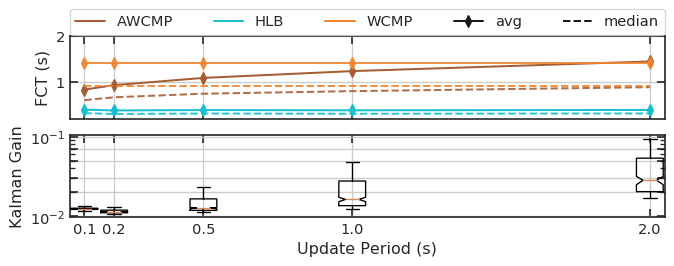

In [393]:
fig, axs = plt.subplots(2, figsize=(8, 2.5), dpi=96, sharex=True, sharey=False)
rate = 0.885
metric = 'fct-avg'
# fig.suptitle('FCT 90p (s)'.format(rate), y=1.06)
i = 0
marker = MARKER_DICT['weight']
for method in period_methods:
    v_median = [np.mean([metric_all[setup][method+'-{:.1f}period'.format(period)][rate]['ep{}'.format(ep)]['fct-p50'] for ep in range(5)]) for period in periods]
    v = [np.mean([metric_all[setup][method+'-{:.1f}period'.format(period)][rate]['ep{}'.format(ep)][metric] for ep in range(5)]) for period in periods]
#         v_90p = [np.mean([metric_all[setup][method+'-{:.1f}period'.format(period)][rate]['ep{}'.format(ep)]['fct-p90'] for ep in range(5)]) for period in periods]
#         v_99p = [np.mean([metric_all[setup][method+'-{:.1f}period'.format(period)][rate]['ep{}'.format(ep)]['fct-p99'] for ep in range(5)]) for period in periods]
    color = COLORS_DICT[method]
#     marker = MARKER_DICT[method]
    linestyle = LINESTYLE_DICT[method]
    axs[i].plot(periods, v, linestyle='-', marker=marker, color=color)
    axs[i].plot(periods, v_median, linestyle='--', color=color, alpha=0.9)
#         axs[i].semilogy(periods, v_90p, linestyle='-.', color=color, alpha=0.9)
#         axs[i].semilogy(periods, v_99p, linestyle=':', color=color, alpha=0.9)
    axs[i].plot(0, 0, color=color, label=method_mapper[method])
    
x = periods
for method in other_methods:
    v_median = [np.mean([metric_all[setup][method][rate]['ep{}'.format(ep)]['fct-p50'] for ep in range(1, 2)])] * len(x)
    v = [np.mean([metric_all[setup][method][rate]['ep{}'.format(ep)][metric] for ep in range(1, 2)])] * len(x)
    color = COLORS_DICT[method]
#     marker = MARKER_DICT[method]
    linestyle = LINESTYLE_DICT[method]
    axs[i].plot(x, v, linestyle='-', marker=marker, color=color, alpha=0.9)
    axs[i].plot(x, v_median, linestyle='--', color=color, alpha=0.9)
    axs[i].plot(0, 0, color=color, label=method_mapper[method])

    
axs[i].plot(0, 0, color='k', linestyle='-', marker=marker, label='avg')
axs[i].plot(0, 0, color='k', linestyle='--', label='median')
axs[i].legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
       ncol=5, mode="expand", borderaxespad=0.)
# axs[i].grid()  
axs[i].set_ylim([0.2, 2.])
axs[i].set_ylabel('FCT (s)')

i = 1
bplot = axs[i].boxplot([ks[period] for period in periods], 
        positions=periods, widths=[0.09]*len(periods), showfliers=False, notch=True)


#         plt.xticks(periods, n_buckets, rotation=30)
axs[i].set_xlabel("Update Period (s)")
axs[i].set_xlim([0.05, 2.05])
axs[i].set_ylabel('Kalman Gain')
axs[i].set_yscale('log')
axs[i].set_yticks([0.01, 0.02, 0.03, 0.05, 0.07, 0.1])

# axs[i].grid()
plt.sca(axs[i])
plt.xticks(periods, periods, rotation=0)
fig.savefig(os.path.join(fig_dir, 'compare-period.pdf'.format(rate)), bbox_inches='tight', transparent=True)